## Financial Modeling 

Let's start with Financial Modeling. First, we identify the characteristics of our dataset. Each entry is presumably taken at the last day of each month from 2020-10-31 to 2024-09-30. To make our model more granular, we can interpolate days in between months for the specified duration. 

We have two approaches.

### Approach 1: 
- Given the assumption that each entry is made at the last day of each month consistently so, we can simply use the dates as cumulative timestamps.
- For example, if an entry was made on February 28 and then another on March 31, we assume that the first and second months had 28 and 31 days, respectively. We then add these values to the total number of days passed before then.
- This approach is simplistic and sufficient for determining general trends quickly, but lacks robustness.

### Approach 2:
- We create a calendar-aware model that leverages "date" library's built-in calendar.
- **Flow**: get the next month's first date with respect to the current month -> subtract one day -> equivalent to last day of current month
- This would allow us to work with the actual number of days passed, hence improving granularity and robustness without much significant difficulty from approach 1; <u>therefore, we shall use approach 2</u>.

In [1]:
import os
cwd = os.getcwd()

In [3]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

In [7]:
path_data = "data/Nat_Gas.csv"
df = pd.read_csv(path_data, parse_dates=["Dates"])

C:\Users\User\AppData\Local\Temp\ipykernel_11432\1752229951.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path_data, parse_dates=["Dates"])


In [8]:
df

,Dates,Prices
0,2020-10-31,10.10
1,2020-11-30,10.30
2,2020-12-31,11.00
3,2021-01-31,10.90
4,2021-02-28,10.90
5,2021-03-31,10.90
6,2021-04-30,10.40
7,2021-05-31,9.84
8,2021-06-30,10.00
9,2021-07-31,10.10


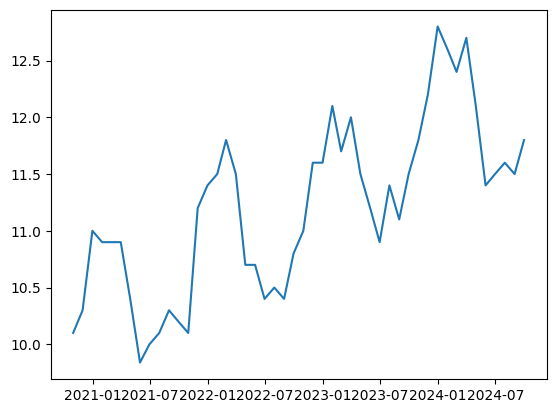

In [9]:
plt.plot(df["Dates"], df["Prices"])

In [12]:
start_date = df["Dates"][0].date()
end_date = df["Dates"][df.shape[0] - 1].date()

months = []
year = start_date.year
month = start_date.month + 1

while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    
    if ( current.year == end_date.year ) and ( current.month == end_date.month ):
        break

    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1

days_passed = [(day - start_date).days for day in months]

In [13]:
def regression(x, y):
    a = x - np.mean(x)
    b = y - np.mean(y)
    
    slope = np.sum(a * b) / np.sum(a * a)

    intercept = np.mean(y) - slope * np.mean(x)
    
    return slope, intercept

10.29104112595228


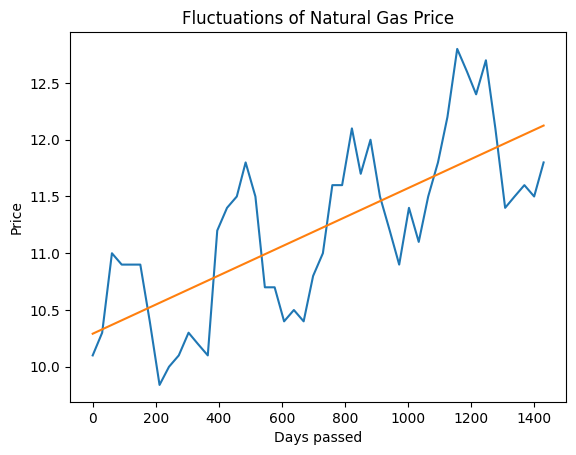

In [14]:
x = np.array(days_passed)
y = df["Prices"]

slope, intercept = regression(x, y)

plt.plot(x,y)
plt.plot(x, x*slope + intercept)
plt.xlabel("Days passed")
plt.ylabel("Price")
plt.title("Fluctuations of Natural Gas Price")
print(intercept)

In [15]:
print(f"start date: {start_date}")
print(f"end date: {end_date}")

start date: 2020-10-31
end date: 2024-09-30


The plot shows a sinusoidal pattern with an upward trend. To get the sinusoidal pattern, we will de-trend the prices expressed in yearly frequencies and perform sinusoidal regression (i.e. a nonlinear projection of cyclical data patterns). 

$$
s(t) = a \cdot \sin\left(\dfrac{2 \pi t}{365}\right) + b \cdot \cos\left(\dfrac{2 \pi t} {365} \right) + trend(t) = A \cdot \sin \left(\dfrac{2\pi t}{365} + \phi \right)
$$

where, 

$$
A = \sqrt{a^2 + b^2} 
$$
$$
\phi = \arctan \left(\dfrac{y}{x}\right)
$$
Note that $\phi$ here is quadrant-agnostic.



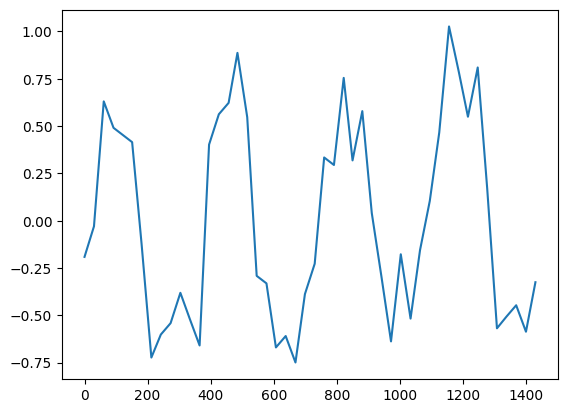

In [16]:
detrend_prices = y - (x*slope + intercept)
plt.plot(x, detrend_prices)

0.6645033338185616
-0.04140626453562664
0.6657921292706733


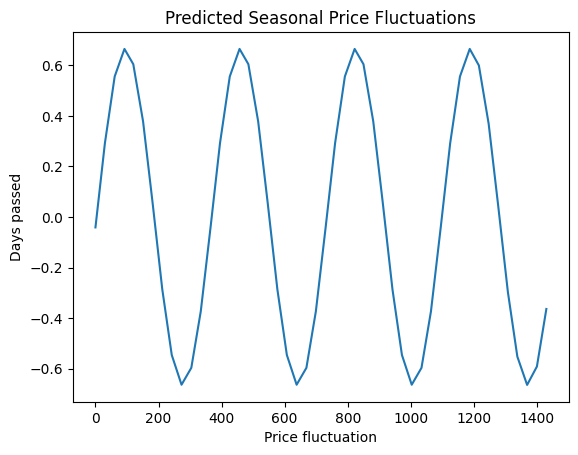

In [17]:
sin_time = np.sin(x * 2 *  np.pi / 365)
cos_time = np.cos(x * 2 * np.pi / 365)

def bilinear_regression(y, x1, x2):
    slope1 = np.sum(y * x1) / np.sum(x1 * x1) 
    slope2 = np.sum(y * x2) / np.sum(x2 * x2) 

    return slope1, slope2

# coefficients of sin and cos components, respectively
a, b = bilinear_regression(detrend_prices, sin_time, cos_time)

amplitude = np.sqrt(a*a + b*b)
shift = np.arctan2(b, a)

result = amplitude * np.sin( (2 * np.pi * x)/365 + shift)
plt.plot(x, result)
plt.xlabel("Price fluctuation")
plt.ylabel("Days passed")
plt.title("Predicted Seasonal Price Fluctuations")
print(a)
print(b)
print(amplitude)

In [18]:
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days 

    # Exact match found
    if days in days_passed:
        return y[days_passed.index(days)]

    # Interpolate / extrapolate
    else:
        trend = days * slope + intercept
        result = amplitude * np.sin( (2 * np.pi * days)/365 + shift) + trend
        return result

We must still find the fitted curve that would represent our trend model. 

In [19]:
continuous_dates = pd.date_range(
    start = pd.Timestamp(start_date),
    end = pd.Timestamp(end_date),
    freq = "D"
)

print(len(continuous_dates))

1431


In [20]:
smooth_prices = [interpolate(dates) for dates in continuous_dates]
print(len(smooth_prices))

1431


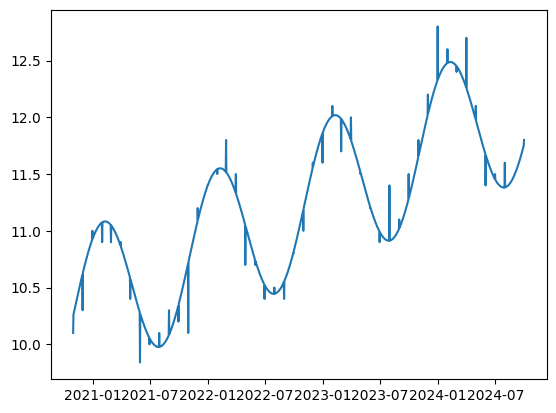

In [21]:
plt.plot(continuous_dates, smooth_prices)

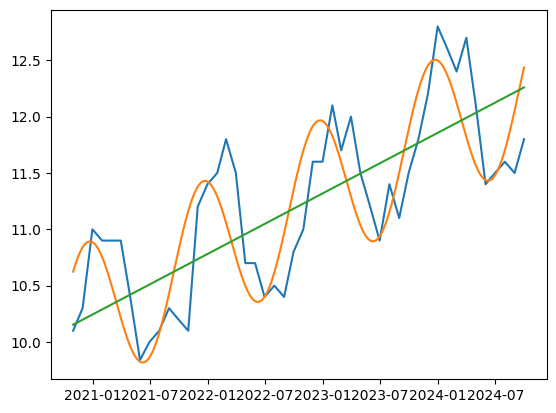

In [22]:
x = np.array(days_passed)
y = np.array(df["Prices"])

fit_amplitude = np.sqrt(a**2 + b**2)
fit_shift = np.arctan2(a, a)

interpolated_prices = y - fit_amplitude * np.sin( (2 * np.pi * x / 365) + fit_shift)

fit_slope, fit_intercept = regression(x, interpolated_prices)

plt.plot(df["Dates"], y)

transformed_x = (continuous_dates - pd.Timestamp(start_date)).days

fit_trend = transformed_x * fit_slope + fit_intercept

fit_curve = fit_amplitude * np.sin(2 * np.pi * transformed_x / 365 + fit_shift) + fit_trend

plt.plot(continuous_dates, fit_curve)

plt.plot(continuous_dates, fit_trend)



Let's explore the variables and how they influence the pricing model
1. Injection Dates and withdrawal dates
   - sort the dates in ascending order
   - compute the interpolated prices in between (using interpolate function, if not given)
   - design fail-safe options to moderate user input
2. Injection / withdrawal rate
3. Maximum storage volume
4. Storage costs

In [60]:
import math 
from datetime import date, timedelta

def interpolate(date):
    days = (date - start_date).days 

    # Exact match found
    if days in days_passed:
        return y[days_passed.index(days)]

    # Interpolate / extrapolate
    else:
        trend = days * slope + intercept
        result = amplitude * np.sin( (2 * np.pi * days)/365 + shift) + trend
        return result

def pricing(start_date, volume, rate):
    days = []
    prices = []
    duration = math.ceil(volume / rate)
    # print(f"duration: {duration}")
    
    for i in range(1, duration + 1):
        # print(i)
        days.append(start_date + timedelta(days=i))

    # print(f"days: {days}")

    for day in days:
        prices.append(interpolate(day))

    return prices

                     
def duration(injection_volume: float, injection_rate: float):
    whole_days = injection_volume // injection_rate
    last_day = ( injection_volume % injection_rate ) / injection_rate
    
    return whole_days, round(last_day, 4)

def charged_cost(injection_volume, injection_rate):
    return injection_volume * injection_rate

def cost(injection_date,    # date 
         injection_volume,  # float
         injection_rate,    # float
         withdrawal_date,   # date
         withdrawal_volume, # float
         withdrawal_rate,   # float
         max_storage,       # float
         storage_rate):     # float

    injection_prices = pricing(injection_date, injection_volume, injection_rate)
    # print(f"injection prices: {injection_prices}\n")
    withdrawal_prices = pricing(withdrawal_date, withdrawal_volume, withdrawal_rate)
    # print(f"withdrawal prices: {withdrawal_prices}\n")

    
    injection_whole_days_average_price = np.mean(injection_prices[:-1]) # modify
    print(f"injection: whole day average price: {injection_whole_days_average_price}\n")

    injection_last_day_price = injection_prices[-1]
    print(f"injection: last day price: {injection_last_day_price}\n")
    
    injection_whole_days, injection_last_day = duration(injection_volume, injection_rate)
    # print(f"whole days: {injection_whole_days}\n")
    # print(f"last day: {injection_last_day}\n")

    # compute for total injection cost
    injection_cost = charged_cost(injection_whole_days, injection_whole_days_average_price) + charged_cost(injection_last_day, injection_last_day_price)
    print(f"injection cost: {injection_cost}\n")
    
    # repeat for withdrawal
    # injection_prices = prices(injection_date, injection_volume, injection_rate)
    # withdrawal_prices = prices(withdrawal_date, withdrawal_volume, withdrawal_rate)
    
    withdrawal_whole_days_average_price = np.mean(withdrawal_prices[:-1]) # modify
    print(f"withdrawal: whole day average price: {withdrawal_whole_days_average_price}\n")
    
    withdrawal_last_day_price = withdrawal_prices[-1]
    print(f"withdrawal: last day price: {withdrawal_last_day_price}\n")
    
    withdrawal_whole_days, withdrawal_last_day = duration(withdrawal_volume, withdrawal_rate)

    # compute for total injection cost
    withdrawal_cost = charged_cost(withdrawal_whole_days, withdrawal_whole_days_average_price) + charged_cost(withdrawal_last_day, withdrawal_last_day_price)
    print(f"withdrawal_cost: {withdrawal_cost}\n")
    
    total_cost = injection_cost + withdrawal_cost
    # print(f" total cost: {total_cost}\n")

    return total_cost
        

In [36]:
temp_whole_day, temp_last_day = duration(100.3, 2.0)
print(temp_whole_day, temp_last_day)
# price_list = pricing(
#     start_date = date(2023, 8, 2),
#     volume = 100,
#     rate = 2)
# temp_x = np.arange(1, 51)
# plt.plot(temp_x, price_list)

50.0 0.15


In [61]:
# Sample input
injection_date = date(2023, 8, 2),    # date 
injection_volume = 100.00,            # float
injection_rate = 2.00,                # float
withdrawal_date = date(2023, 9, 2),   # date
withdrawal_volume = 100.00,           # float
withdrawal_rate = 2.00,               # float
max_storage = 100.00,                 # float
storage_rate = 0.00

sample = cost(injection_date = date(2023, 8, 2),    # date 
     injection_volume = 100.00,  # float
     injection_rate = 2.00,    # float
     withdrawal_date = date(2023, 9, 2),   # date
     withdrawal_volume = 100.00, # float
     withdrawal_rate = 2.00,   # float
     max_storage = 100.00,       # float
     storage_rate = 0.00)

print(88*"-" + f"""\nGiven the following input information:
injection date: {injection_date}
injection_volume: {injection_volume}
injection rate: {injection_rate}

withdrawal date: {withdrawal_date}
withdrawal volume: {withdrawal_volume}
withdrawal rate: {withdrawal_rate}

max storage = {max_storage}
storage cost = {storage_rate}, 

The total cost for such a transaction based on our pricing model above is...
Total Cost: {sample}
""")

injection: whole day average price: 11.015720094800894

injection: last day price: 11.189726270486092

injection cost: 550.7860047400447

withdrawal: whole day average price: 11.26627810828586

withdrawal: last day price: 11.540249800575188

withdrawal_cost: 563.313905414293

----------------------------------------------------------------------------------------
Given the following input information:
injection date: (datetime.date(2023, 8, 2),)
injection_volume: (100.0,)
injection rate: (2.0,)

withdrawal date: (datetime.date(2023, 9, 2),)
withdrawal volume: (100.0,)
withdrawal rate: (2.0,)

max storage = (100.0,)
storage cost = 0.0, 

The total cost for such a transaction based on our pricing model above is...
Total Cost: 1114.0999101543377



This is a basic financial modelling example that takes into account only the injection/withdrawal duration (i.e., how many days did it take to inject/withdraw x amount of Natural Gas) and their corresponding prices. This does not yet take into account the cumulative storage cost.